# Propagation of Hollow Core Waveguide with Walls of Different Thicknesses

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
from slab import SlabExact
from scipy.optimize import newton
from scipy.integrate import quad
plt.style.use('dark_background')
%matplotlib widget

# Setup Waveguide and input fields

In [2]:
Ts = [6.5, 2, 14, 3, 6.5]

A = SlabExact(scale=1e-5, Ts=Ts,
              ns=[1, 1.44, 1, 1.44, 1], xrefs=[200, 200, 400, 200, 200],
              symmetric=True)

In [3]:
b = 1.25

def quadratic_piecewise(x):
    conds = [(x<-b), ((-b<=x)*(x<=b)), (x>b)]
    funcs = [0, lambda x: 1 - (x / b)**2, 0]
    return np.piecewise(x, conds, funcs)

f0 = quadratic_piecewise

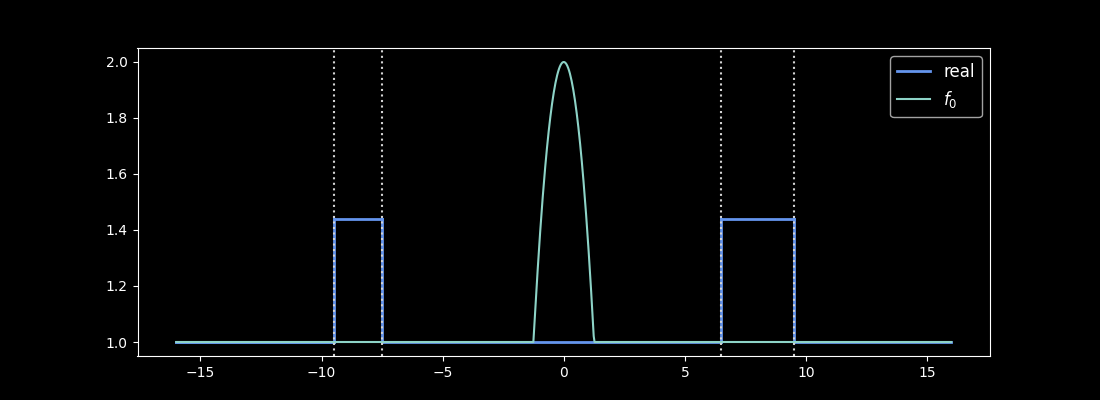

In [4]:
A.plot_refractive_index(color='cornflowerblue', linewidth=2);
A.add_1d_plot(lambda x: f0(x) + 1, label='$f_0$')

## Find Left and Right resonant wavelengths

In [5]:
resonant_wls_L = 2 * A.Ts[1] *  np.array([1/l for l in range(1,9)]) * np.sqrt(A.n_high**2 - A.n0**2) * A.scale
resonant_wls_R = 2 * A.Ts[3] *  np.array([1/l for l in range(1,9)]) * np.sqrt(A.n_high**2 - A.n0**2) * A.scale

print('shared wavelengths: ', set(resonant_wls_L).intersection(set(resonant_wls_R)))

shared wavelengths:  {2.072293415518179e-05, 1.0361467077590895e-05}


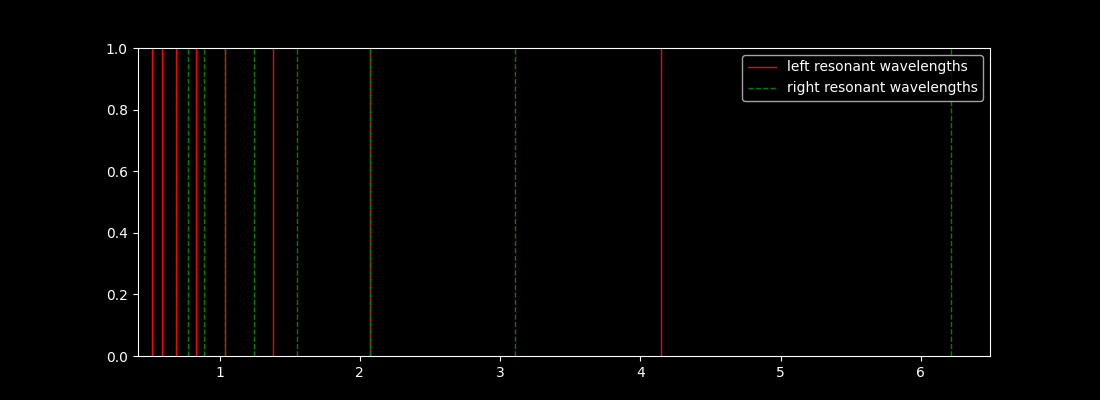

In [6]:
plt.close('all')
fig, ax = plt.subplots(1, figsize=(11,4))
ax.axvline(resonant_wls_L[0] / A.scale, linewidth=1, color='r', label='left resonant wavelengths')
ax.axvline(resonant_wls_R[0] / A.scale, linewidth=1, color='g', linestyle='--', label='right resonant wavelengths')

for r in resonant_wls_L[1:]:
    ax.axvline(r/A.scale, linewidth=1, color='r')
for r in resonant_wls_R[1:]:
    ax.axvline(r/A.scale, linewidth=1, color='g', linestyle='--')
plt.legend()

In [7]:
left_resonant_wl = resonant_wls_L[0]
right_resonant_wl = resonant_wls_R[1]
double_resonant_wl = resonant_wls_L[1]
low_loss_wl = (left_resonant_wl + right_resonant_wl)/2

left_resonant_wl, right_resonant_wl, low_loss_wl, double_resonant_wl

(4.144586831036358e-05,
 3.108440123277268e-05,
 3.626513477156813e-05,
 2.072293415518179e-05)

# Study

We note that guided fields likely won't play a role because we are either at low loss or at resonance, so guided modes are well contained to walls or cutoff.  May need to consider them when we are doing resonance at a single wall however.  We begin by studying the effects using just the leaky mode fields.

In [8]:

A = SlabExact(scale=1e-5, Ts=Ts,
              ns=[1, 1.44, 1, 1.44, 1], xrefs=[200, 200, 400, 200, 200],
              symmetric=True, wl=low_loss_wl)

L = SlabExact(scale=1e-5, Ts=Ts,
              ns=[1, 1.44, 1, 1.44, 1], xrefs=[200, 200, 400, 200, 200],
              symmetric=True, wl=left_resonant_wl)

R = SlabExact(scale=1e-5, Ts=Ts,
              ns=[1, 1.44, 1, 1.44, 1], xrefs=[200, 200, 400, 200, 200],
              symmetric=True, wl=right_resonant_wl)

D = SlabExact(scale=1e-5, Ts=Ts,
              ns=[1, 1.44, 1, 1.44, 1], xrefs=[200, 200, 400, 200, 200],
              symmetric=True, wl=double_resonant_wl)

# Low loss field

Propagation with this one is hard, so we opt for finding the leaky field.

## Guided portion

Surprisingly, this one has a non-trivial guided portion.

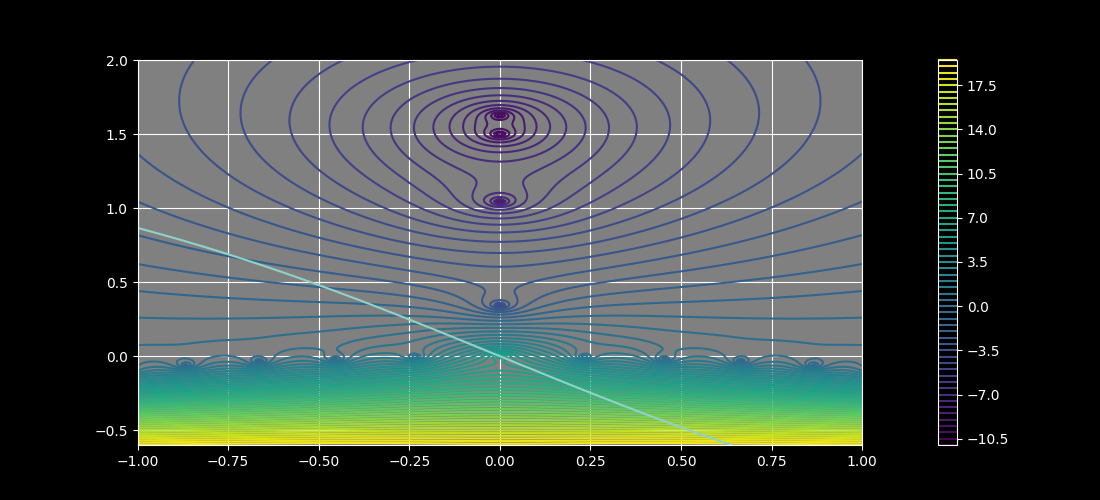

In [9]:
A.determinant_plot(-1, 1, -.6, 2);

In [10]:
Zg = newton(A.determinant_Z, np.array(.3j))
Fg = A.fields_Z(Zg)

alpha = quad(lambda x: f0(x) * Fg(x), -b, b, complex_func=True)[0]  / quad(lambda x: Fg(x) * Fg(x), -12, 12, complex_func=True)[0]

guided_x = lambda x: alpha * Fg(x)
Guided = lambda x, z: alpha * Fg(x, z)

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

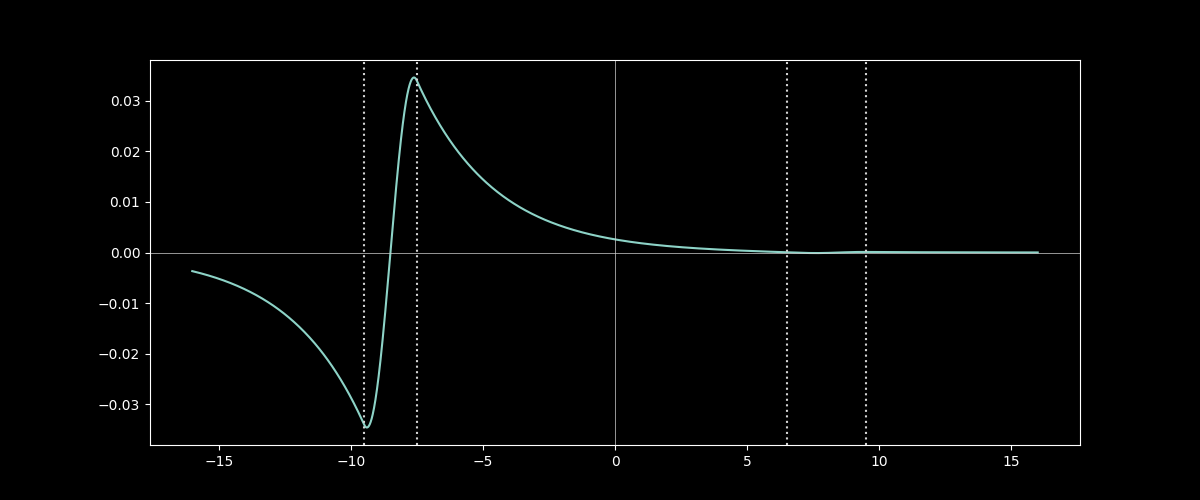

In [11]:
A.plot_field_1d(guided_x)

In [12]:
Propagator_ClassA = A.propagator()


In [13]:
contour = A.real_contour(0.000001, .38, 100)

P_prop1Ae = Propagator_ClassA(contour, f0=f0, Lx=-b, Rx=b)
P_prop1Ao = Propagator_ClassA(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


In [14]:
contour = A.real_contour(.38, .435, 100)

P_prop2Ae = Propagator_ClassA(contour, f0=f0, Lx=-b, Rx=b)
P_prop2Ao = Propagator_ClassA(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


In [15]:
contour = A.real_contour(.435, A.Z_evanescent.real, 300)

P_prop3Ae = Propagator_ClassA(contour, f0=f0, Lx=-b, Rx=b)
P_prop3Ao = Propagator_ClassA(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

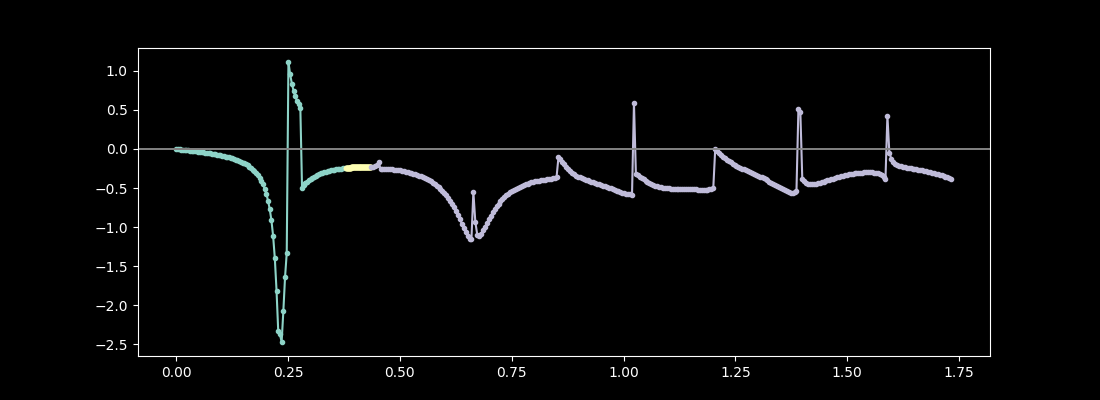

In [16]:
P_prop1Ae.plot_transform()
P_prop2Ae.plot_transform(ax=plt.gca())
P_prop3Ae.plot_transform(ax=plt.gca())

## Evanescent Portion

In [17]:
contour = A.real_contour(A.Z_evanescent.real, 7, 100)

P_ev1Ae = Propagator_ClassA(contour, f0=f0, Lx=-b, Rx=b)
P_ev1Ao = Propagator_ClassA(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

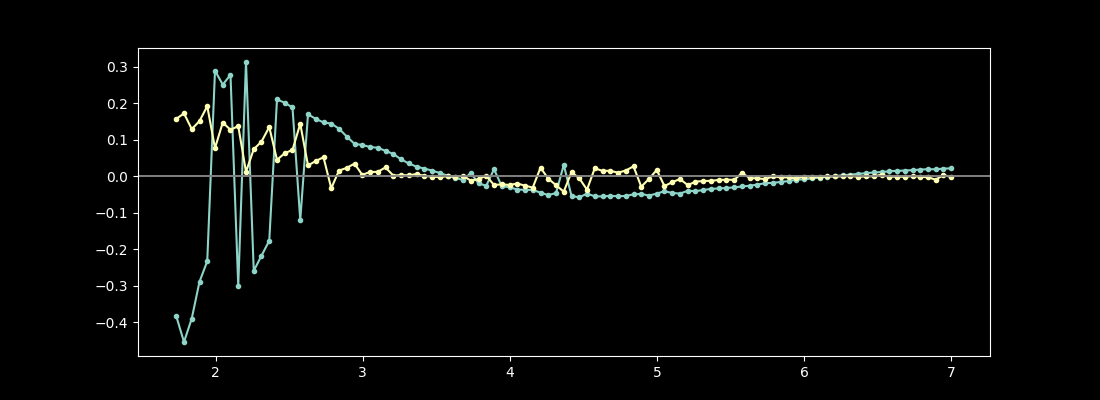

In [18]:
P_ev1Ae.plot_transform()
P_ev1Ao.plot_transform(ax=plt.gca())

In [19]:
contour = A.real_contour(7, 14, 100)

P_ev2Ae = Propagator_ClassA(contour, f0=f0, Lx=-b, Rx=b)
P_ev2Ao = Propagator_ClassA(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

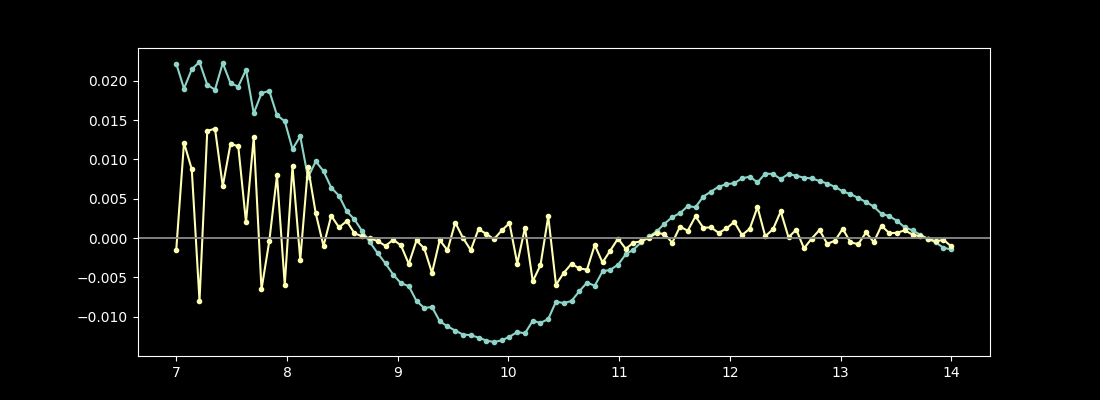

In [20]:
P_ev2Ae.plot_transform()
P_ev2Ao.plot_transform(ax=plt.gca())

## Functions and Plots

In [21]:
propfuncsA = [
    P_prop1Ae,
    P_prop1Ao,
    P_prop2Ae,
    P_prop2Ao,
    P_prop3Ae,
    P_prop3Ao,
]

evfuncsA = [
    P_ev1Ae,
    P_ev1Ao,
    P_ev2Ae,
    P_ev2Ao,
]

In [22]:
x0 = 0
z0 = 0

propA_x = lambda x: sum([f.slice_propagate(x, z0, 'z') for f in propfuncsA])
evA_x = lambda x: sum([f.slice_propagate(x, z0, 'z') for f in evfuncsA]) 
fullA_x = lambda x: propA_x(x) + evA_x(x) + guided_x(x)

diffA_x = lambda x: f0(x) - fullA_x(x)

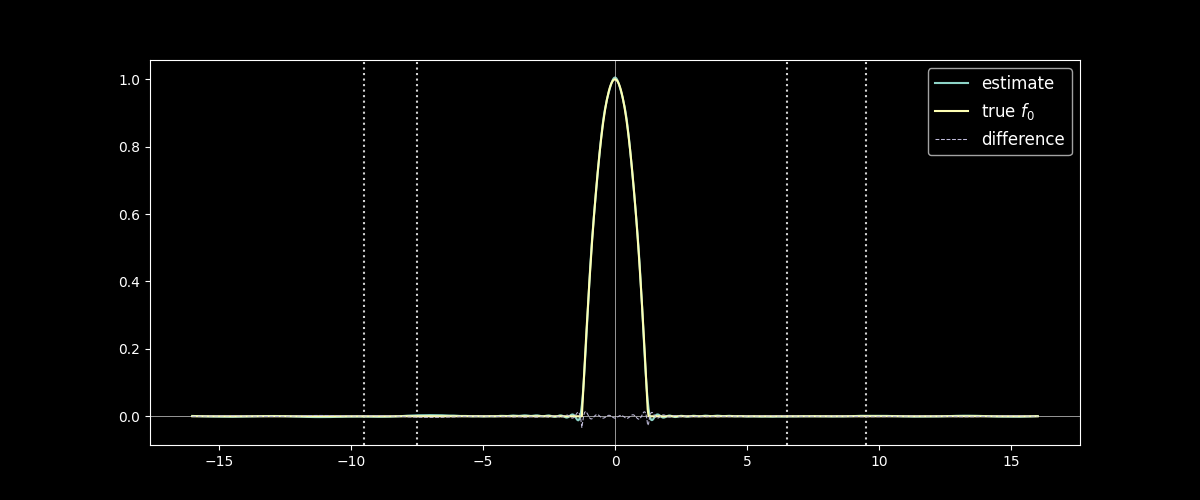

In [23]:
A.plot_field_1d(fullA_x, label='estimate') 
A.add_1d_plot(f0, label='true $f_0$')
A.add_1d_plot(diffA_x, label='difference', linewidth=.75, linestyle='--')
# plt.gca().set_xlim(-3,3)

In [24]:
PropA = lambda x, z: sum([f.propagate(x, z) for f in propfuncsA])
EvA = lambda x, z: sum([f.propagate(x, z) for f in evfuncsA]) 
FullA = lambda x, z: PropA(x, z) + EvA(x, z) + Guided(x, z)

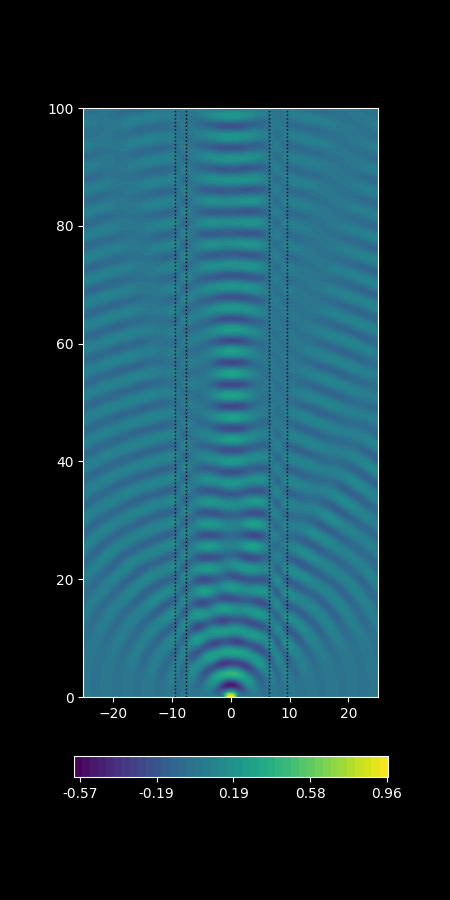

In [25]:
A.plot_field_2d(FullA, xs=np.linspace(-25, 25, 100), zs=np.linspace(0, 100, 200));

# Left Resonant Field

The leaky mode representation doesn't work as well here, as we've been finding, so we go for propagation.

In [26]:
Propagator_ClassL = L.propagator()

## Propagating Portion

In [27]:
contour = L.real_contour(0.000001, L.Z_evanescent.real, 300)

P_prop1Le = Propagator_ClassL(contour, f0=f0, Lx=-b, Rx=b)
P_prop1Lo = Propagator_ClassL(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

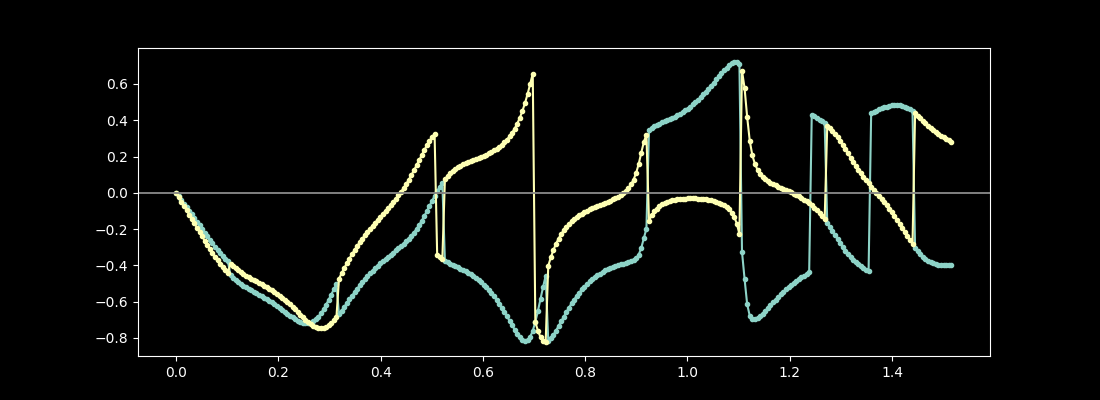

In [28]:
P_prop1Le.plot_transform()
P_prop1Lo.plot_transform(ax=plt.gca())

## Evanescent Portion

In [29]:
contour = L.real_contour(L.Z_evanescent.real, 7, 100)

P_ev1Le = Propagator_ClassL(contour, f0=f0, Lx=-b, Rx=b)
P_ev1Lo = Propagator_ClassL(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

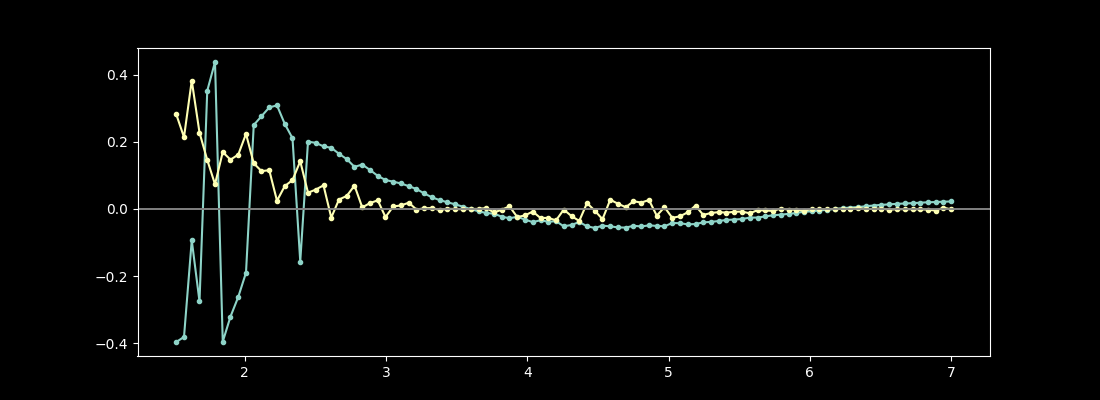

In [30]:
P_ev1Le.plot_transform()
P_ev1Lo.plot_transform(ax=plt.gca())

In [31]:
contour = L.real_contour(7, 14, 100)

P_ev2Le = Propagator_ClassL(contour, f0=f0, Lx=-b, Rx=b)
P_ev2Lo = Propagator_ClassL(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

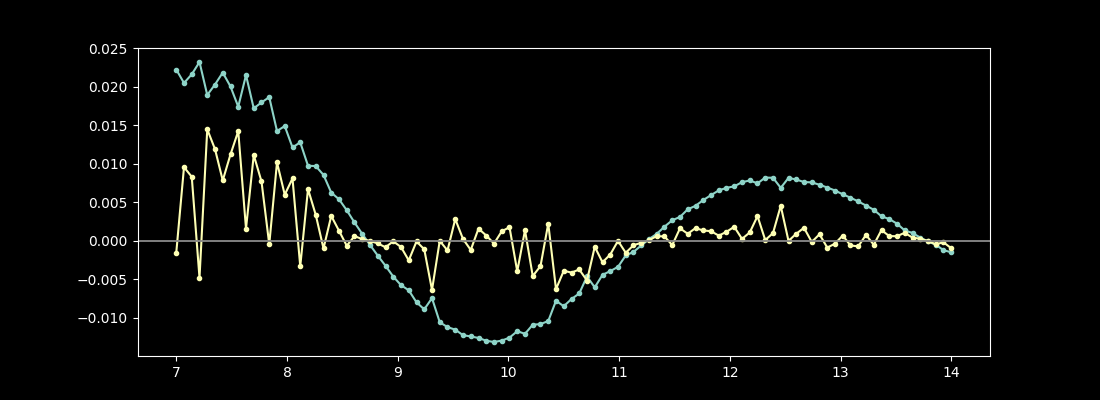

In [32]:
P_ev2Le.plot_transform()
P_ev2Lo.plot_transform(ax=plt.gca())

## Functions and Plots

In [33]:
propfuncsL = [
    P_prop1Le,
    P_prop1Lo,
]

evfuncsL = [
    P_ev1Le,
    P_ev1Lo,
    P_ev2Le,
    P_ev2Lo,
]

In [34]:
x0 = 0
z0 = 0

propL_x = lambda x: sum([f.slice_propagate(x, z0, 'z') for f in propfuncsL])
evL_x = lambda x: sum([f.slice_propagate(x, z0, 'z') for f in evfuncsL]) 
fullL_x = lambda x: propL_x(x) + evL_x(x)

diffL_x = lambda x: f0(x) - fullL_x(x)

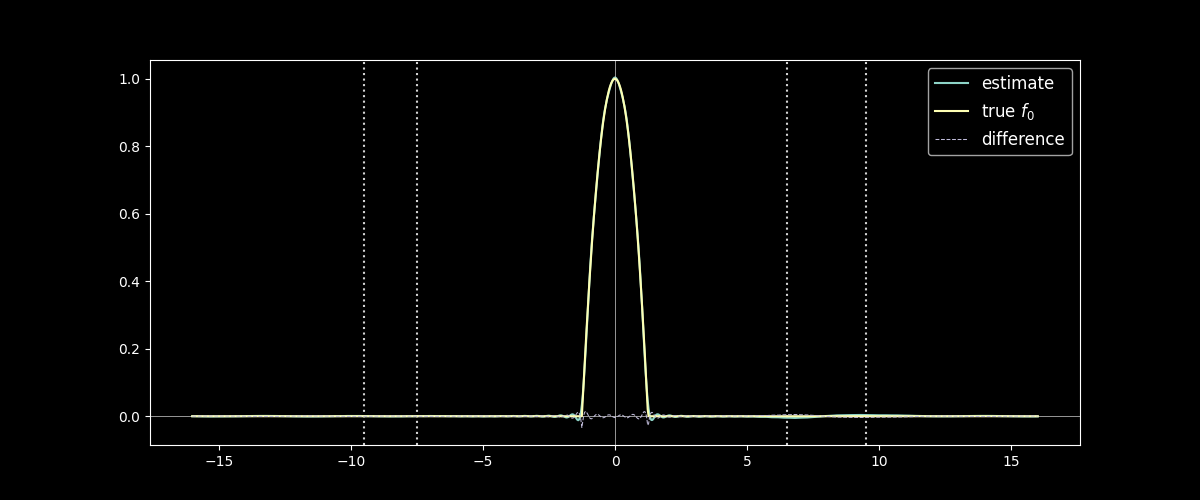

In [35]:
A.plot_field_1d(fullL_x, label='estimate') 
A.add_1d_plot(f0, label='true $f_0$')
A.add_1d_plot(diffL_x, label='difference', linewidth=.75, linestyle='--')
# plt.gca().set_xlim(-3,3)

In [36]:
PropL = lambda x, z: sum([f.propagate(x, z) for f in propfuncsL])
EvL = lambda x, z: sum([f.propagate(x, z) for f in evfuncsL]) 
FullL = lambda x, z: PropL(x, z) + EvL(x, z)

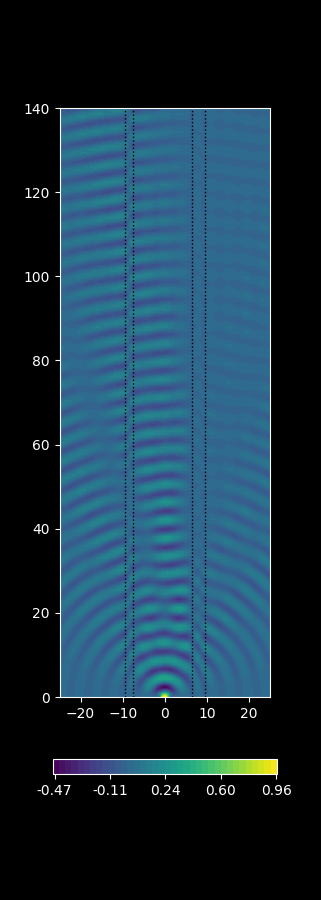

In [37]:
A.plot_field_2d(FullL, xs=np.linspace(-25, 25, 100), zs=np.linspace(0, 140, 200));

In [38]:
# zmin, zmax=0, 50
# A.plot_field_2d_surface(FullL, xs=np.linspace(-20, 20, 200), colorbar=False, zoom=2.75,
#                 azim=-90, elev=40, zmin=0,
#                 zmax=zmax, zref=350,
#                 rstride=1, cstride=1,
#                );

# Right resonance Propagate Radiation Field

In [39]:
Propagator_ClassR = R.propagator()

## Propagating Portion

In [40]:
contour = R.real_contour(0.000001, R.Z_evanescent.real, 300)

P_prop1Re = Propagator_ClassR(contour, f0=f0, Lx=-b, Rx=b)
P_prop1Ro = Propagator_ClassR(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

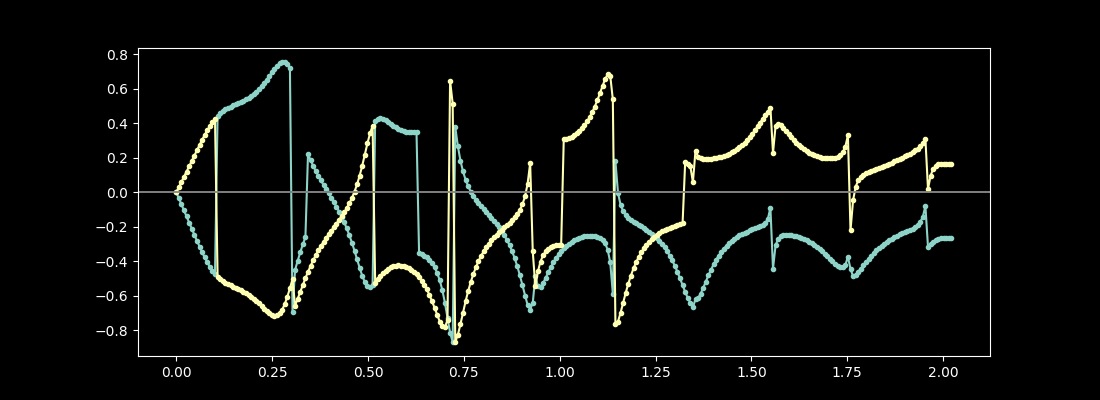

In [41]:
P_prop1Re.plot_transform()
P_prop1Ro.plot_transform(ax=plt.gca())

## Evanescent Portion

In [42]:
contour = R.real_contour(R.Z_evanescent.real, 7, 100)

P_ev1Re = Propagator_ClassR(contour, f0=f0, Lx=-b, Rx=b)
P_ev1Ro = Propagator_ClassR(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

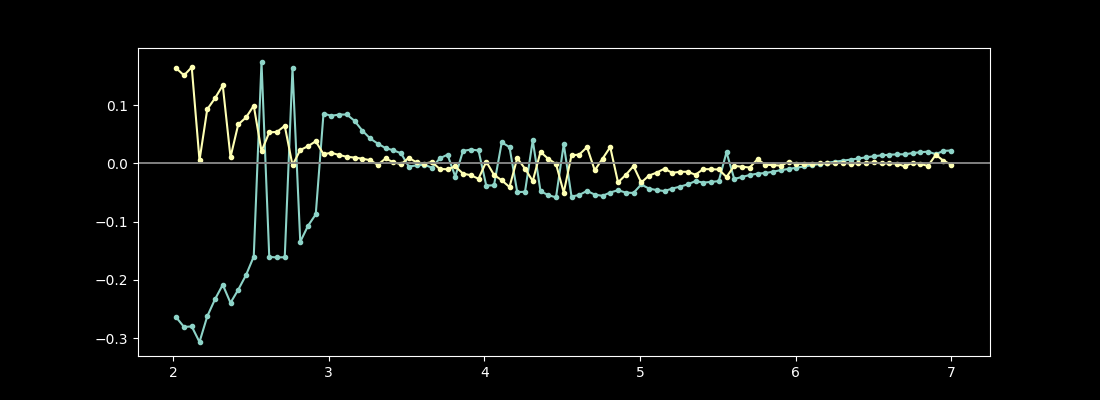

In [43]:
P_ev1Re.plot_transform()
P_ev1Ro.plot_transform(ax=plt.gca())

In [44]:
contour = R.real_contour(7, 14, 300)

P_ev2Re = Propagator_ClassR(contour, f0=f0, Lx=-b, Rx=b)
P_ev2Ro = Propagator_ClassR(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

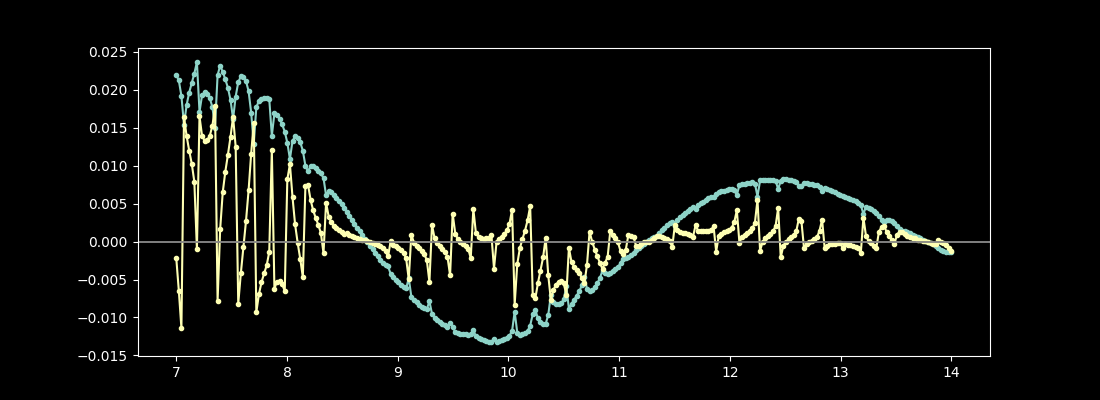

In [45]:
P_ev2Re.plot_transform()
P_ev2Ro.plot_transform(ax=plt.gca())

## Functions and Plots


In [46]:
propfuncsR = [
    P_prop1Re,
    P_prop1Ro,
]

evfuncsR = [
    P_ev1Re,
    P_ev1Ro,
    P_ev2Re,
    P_ev2Ro,
]

In [47]:
x0 = 0
z0 = 0

propR_x = lambda x: sum([f.slice_propagate(x, z0, 'z') for f in propfuncsR])
evR_x = lambda x: sum([f.slice_propagate(x, z0, 'z') for f in evfuncsR]) 
fullR_x = lambda x: propR_x(x) + evR_x(x)
diffR_x = lambda x: f0(x) - fullR_x(x)

PropR = lambda x, z: sum([f.propagate(x, z) for f in propfuncsR])
EvR = lambda x, z: sum([f.propagate(x, z) for f in evfuncsR]) 
FullR = lambda x, z: PropR(x, z) + EvR(x, z)

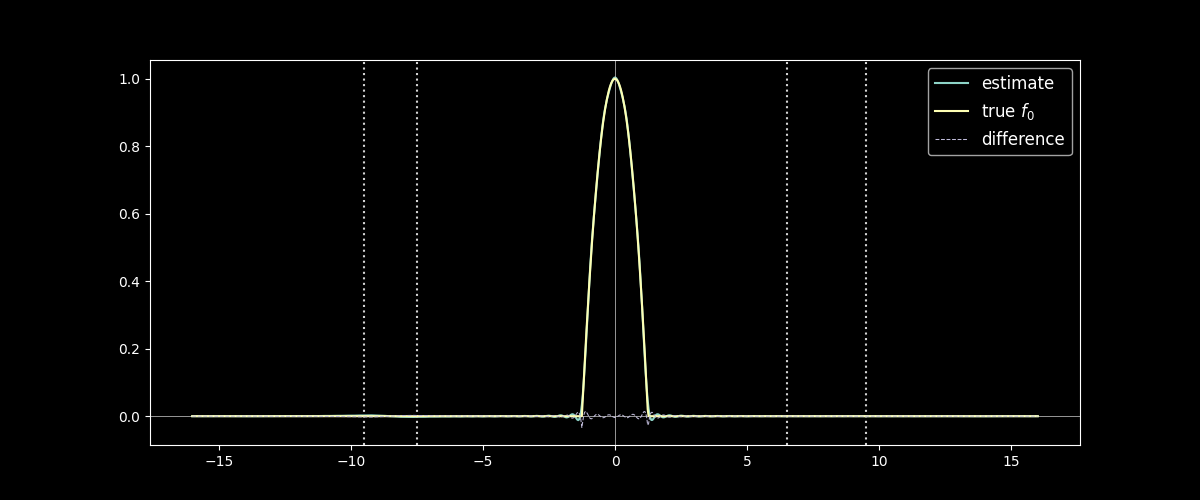

In [48]:
A.plot_field_1d(fullR_x, label='estimate') 
A.add_1d_plot(f0, label='true $f_0$')
A.add_1d_plot(diffR_x, label='difference', linewidth=.75, linestyle='--')
# plt.gca().set_xlim(-3,3)

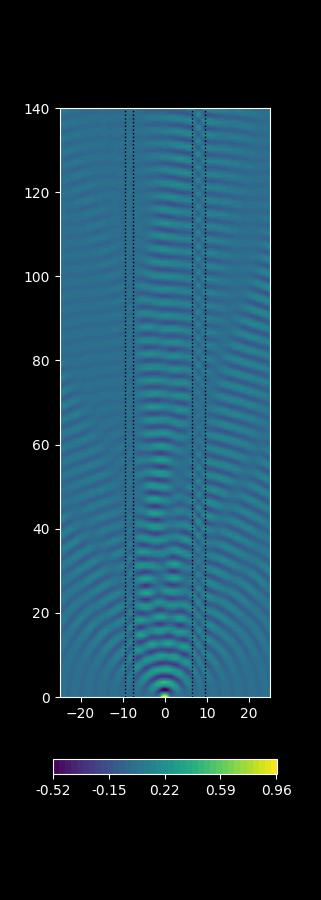

In [49]:
A.plot_field_2d(FullR, xs=np.linspace(-25, 25, 100), zs=np.linspace(0, 140, 200));

# Double resonance Propagate Radiation Field

In [50]:
Propagator_ClassD = D.propagator()

In [51]:
contour = D.real_contour(0.000001, D.Z_evanescent.real, 300)

P_prop1De = Propagator_ClassD(contour, f0=f0, Lx=-b, Rx=b)
P_prop1Do = Propagator_ClassD(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

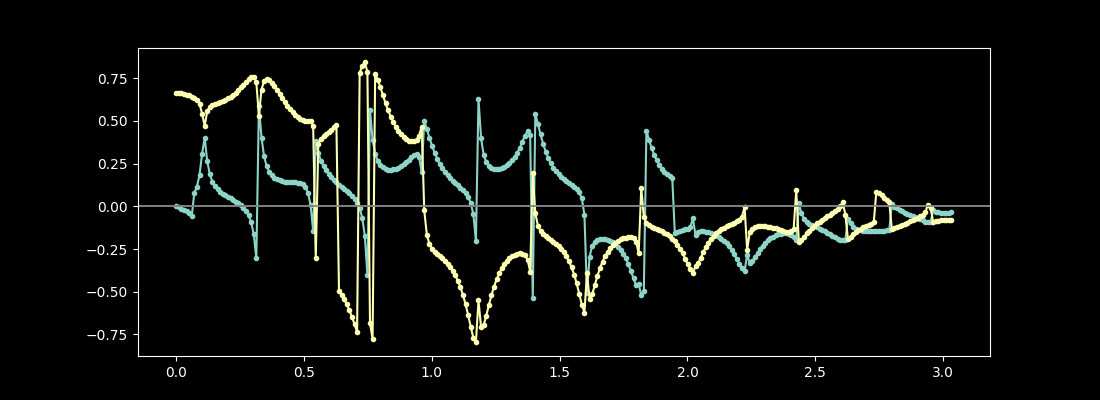

In [52]:
P_prop1De.plot_transform()
P_prop1Do.plot_transform(ax=plt.gca())

### Evanescent Portion

In [53]:
contour = D.real_contour(D.Z_evanescent.real, 7, 100)

P_ev1De = Propagator_ClassD(contour, f0=f0, Lx=-b, Rx=b)
P_ev1Do = Propagator_ClassD(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

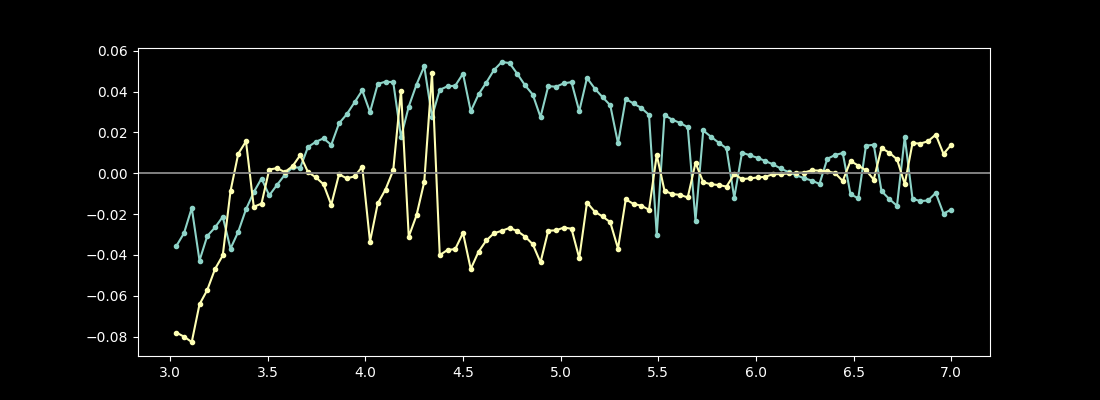

In [54]:
P_ev1De.plot_transform()
P_ev1Do.plot_transform(ax=plt.gca())

In [55]:
contour = D.real_contour(7, 14, 300)

P_ev2De = Propagator_ClassD(contour, f0=f0, Lx=-b, Rx=b)
P_ev2Do = Propagator_ClassD(contour, f0=f0, Lx=-b, Rx=b, sign='-1')


(<Figure size 1100x400 with 1 Axes>, <Axes: >)

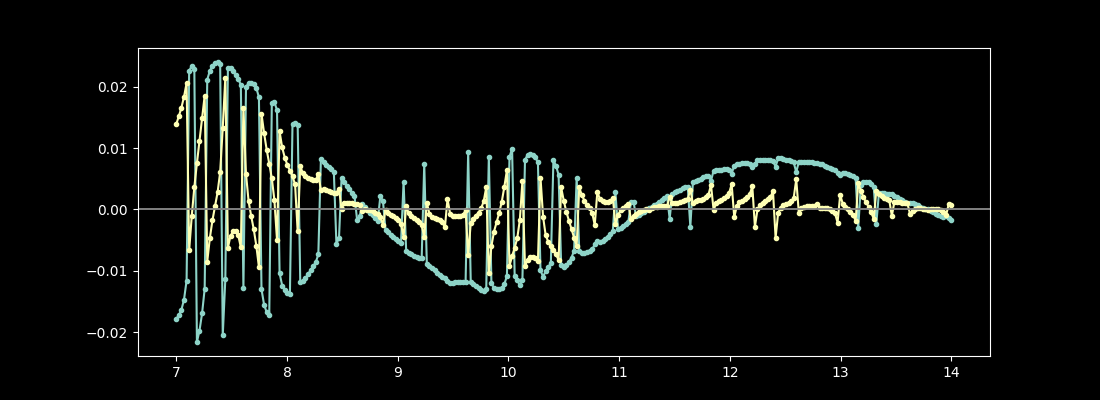

In [56]:
P_ev2De.plot_transform()
P_ev2Do.plot_transform(ax=plt.gca())

## Cross sections at input


In [57]:
propfuncsD = [
    P_prop1De,
    P_prop1Do,
]

evfuncsD = [
    P_ev1De,
    P_ev1Do,
    P_ev2De,
    P_ev2Do,
]

In [58]:
x0 = 0
z0 = 0

propD_x = lambda x: sum([f.slice_propagate(x, z0, 'z') for f in propfuncsD])
evD_x = lambda x: sum([f.slice_propagate(x, z0, 'z') for f in evfuncsD]) 
fullD_x = lambda x: propD_x(x) + evD_x(x)

diffD_x = lambda x: f0(x) - fullD_x(x)

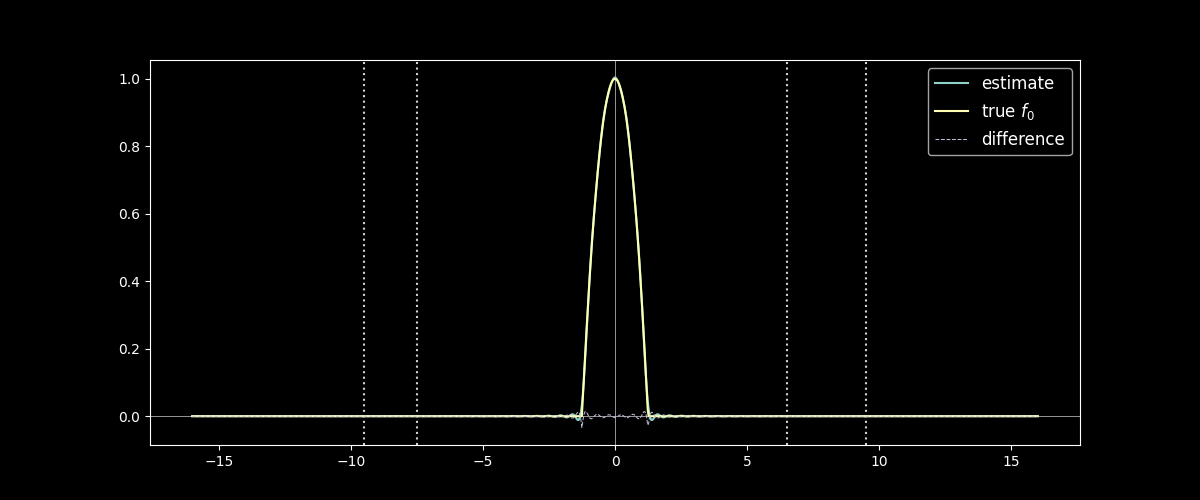

In [59]:
A.plot_field_1d(fullD_x, label='estimate') 
A.add_1d_plot(f0, label='true $f_0$')
A.add_1d_plot(diffD_x, label='difference', linewidth=.75, linestyle='--')
# plt.gca().set_xlim(-3,3)

#### Contour Plot Contour Plot

In [60]:
PropD = lambda x, z: sum([f.propagate(x, z) for f in propfuncsD])
EvD = lambda x, z: sum([f.propagate(x, z) for f in evfuncsD]) 
FullD = lambda x, z: PropD(x, z) + EvD(x, z)

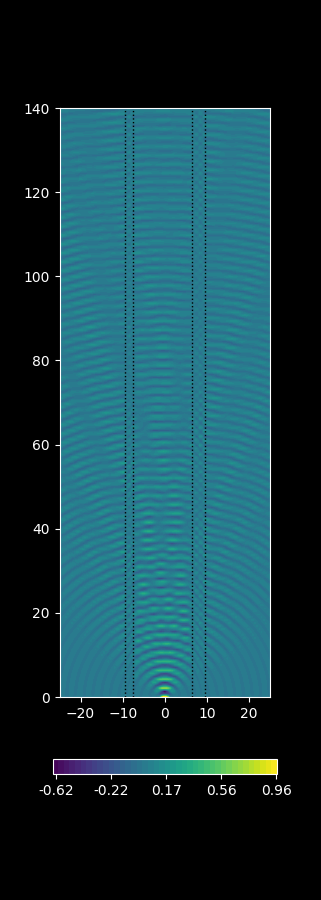

In [61]:
A.plot_field_2d(FullD, xs=np.linspace(-25, 25, 100), zs=np.linspace(0, 140, 200));

# Comparison Plots

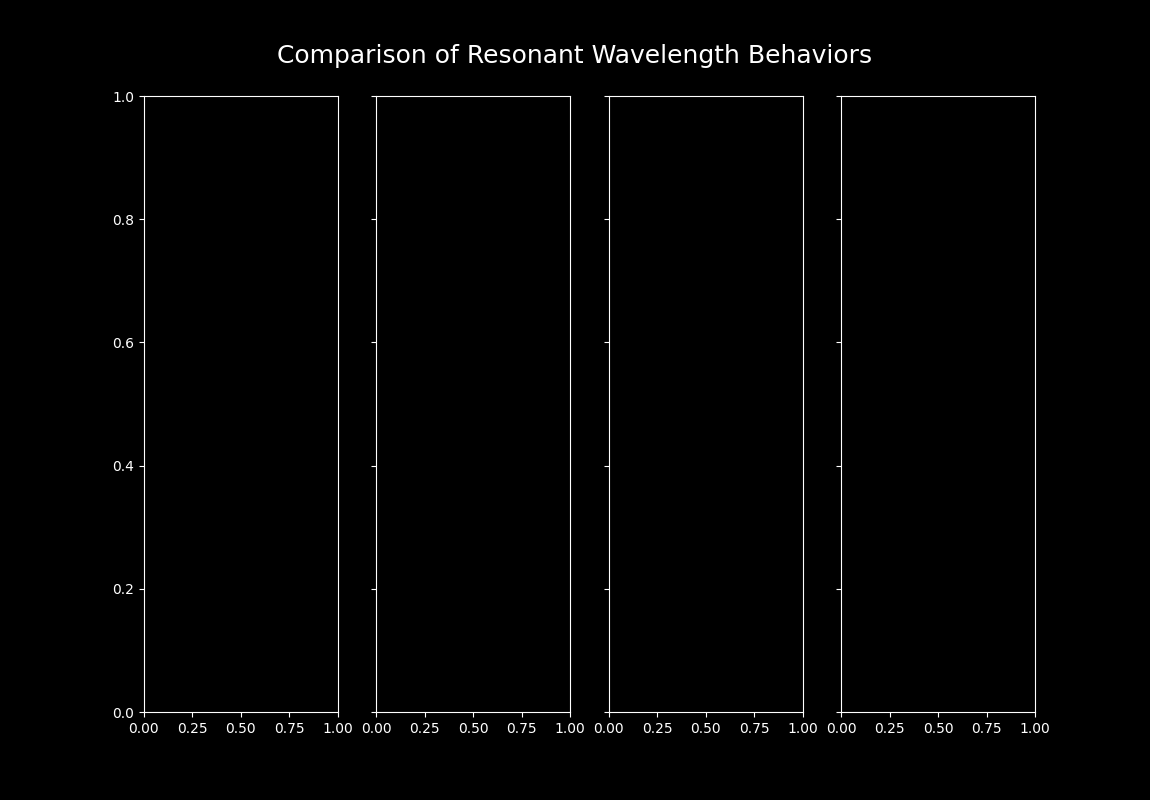

In [77]:
plt.close('all')
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(11.5,8))

xs = np.linspace(-35, 35, 300)
zmin = 0
zmax = 200
zref = 500
levels = 50
vmin, vmax = -.5, .5
Rho_lineargs = {'lw': .125, 'ls': '-', 'c': 'k'}
zs = np.linspace(zmin, zmax, zref)
fig.suptitle('\nComparison of Resonant Wavelength Behaviors', fontsize=18);

In [78]:
A.add_2d_plot(FullA, xs=xs, zs=zs, ax=ax1, colorbar=False, Rho_lineargs=Rho_lineargs,
              colorbar_format='%0.2f', levels=levels, shrink=.9, vmin=vmin, vmax=vmax);
ax1.set_xlabel('\nNon-Resonant Wavelength', fontsize=11)

Text(0.5, 117.4444444444444, '\nNon-Resonant Wavelength')

In [79]:
L.add_2d_plot(FullL, xs=xs, zs=zs, ax=ax2, colorbar=False, Rho_lineargs=Rho_lineargs,
              colorbar_format='%0.2f', shrink=.9, levels=levels, vmin=vmin, vmax=vmax);
ax2.set_xlabel('\nLeft Wall Resonance', fontsize=11)

Text(0.5, 117.4444444444444, '\nLeft Wall Resonance')

In [80]:
R.add_2d_plot(FullR, xs=xs, zs=zs, ax=ax3, colorbar=False, Rho_lineargs=Rho_lineargs,
              colorbar_format='%0.2f', shrink=.9, levels=levels, vmin=vmin, vmax=vmax);
ax3.set_xlabel('\nRight Wall Resonance', fontsize=10)

Text(0.5, 117.4444444444444, '\nRight Wall Resonance')

In [81]:
D.add_2d_plot(FullD, xs=xs, zs=zs, ax=ax4, colorbar=False, Rho_lineargs=Rho_lineargs,
              colorbar_format='%0.2f', shrink=.9, levels=levels, vmin=vmin, vmax=vmax);
ax4.set_xlabel('\nDouble Wall Resonance', fontsize=10)

Text(0.5, 117.4444444444444, '\nDouble Wall Resonance')

# Previous Work: Leaky field of Left resonant wavelength.

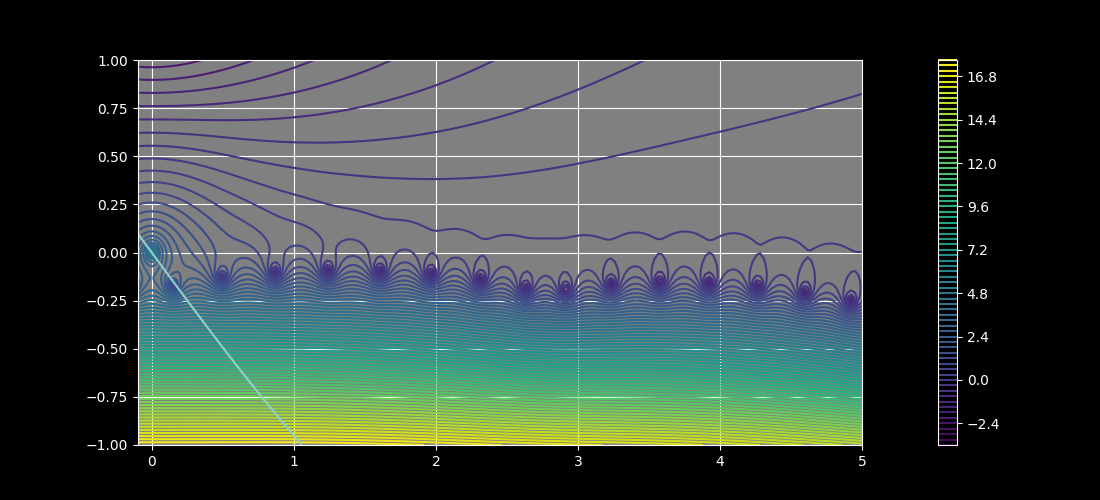

In [17]:
L.determinant_plot(-.1, 5, -1, 1);

In [18]:
guesses = [
    .5-.1j, .85-.09j, 1.25 - .5j, 1.6-.4j,
    1.9-.5j, 2.35 - .09j, 2.65-.2j, 2.9 - .2j,
    3.2 - .2j, 3.5 - .15j, 3.9 - .18j, 4.2 - .18j,
    4.6 - .22j,
]

In [19]:
Z_leakysL = np.array([newton(L.determinant_Z, np.array(guess)) for guess in guesses])

for i in range(len(Z_leakysL)):
    if Z_leakysL[i].imag > 0:
        Z_leakysL[i] = Z_leakysL[i].conj()
    plt.plot(Z_leakysL[i].real, Z_leakysL[i].imag, marker='o')

In [20]:
Propagator_ClassL = L.propagator()


In [21]:
P_leakyL = []

for Z in Z_leakysL:
    PZe = Propagator_ClassL(L.circular_contour(-Z, 1e-7, 5), f0=f0, Lx=-b, Rx=b, sign='+1')
    PZo = Propagator_ClassL(L.circular_contour(-Z, 1e-7, 5), f0=f0, Lx=-b, Rx=b, sign='-1')
    P_leakyL.append(PZe)
    P_leakyL.append(PZo)

In [22]:
x0 = 0
z0 = 0

leaky_xL = lambda x : sum([P.slice_propagate(x, z0, 'z') for P in P_leakyL])
leaky_zL = lambda z : sum([P.slice_propagate(z, x0, 'x') for P in P_leakyL])
LeakyL = lambda x, z : sum([P.propagate(x, z) for P in P_leakyL])

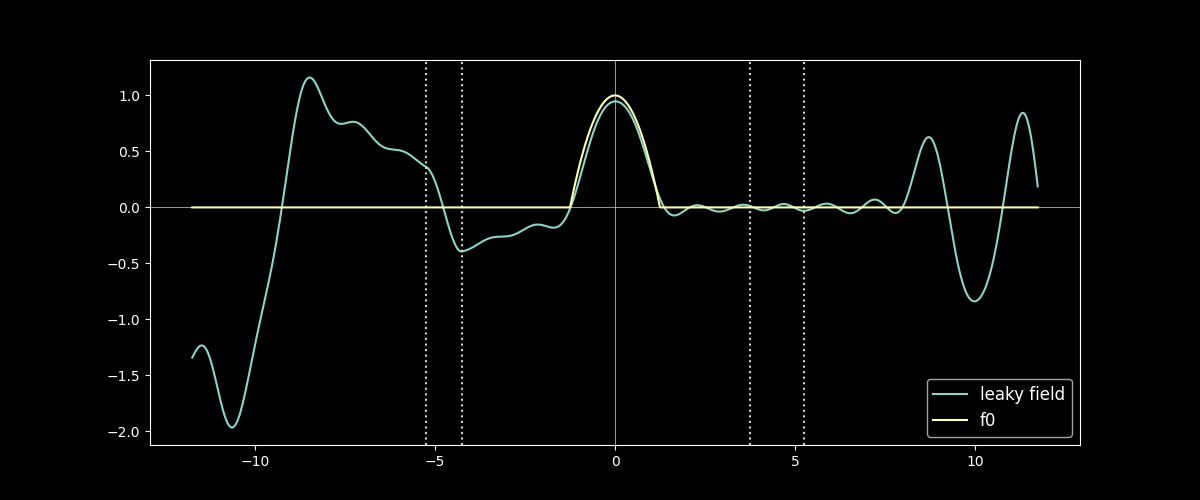

In [23]:
A.plot_field_1d(leaky_xL, label='leaky field');
A.add_1d_plot(f0, label='f0')

Right, leaky modes aren't the full story at resonance wavelengths.  Need to either include the SDP or just do direct propagation along the real axis.  The latter might be easier now since the leaky modes have moved away from that axis.